# Data Cleaning: Cafe Sales Dataset

This notebook demonstrates the process of cleaning and standardizing a cafe sales dataset. The steps include handling missing values, correcting data types, and visualizing the effects of cleaning operations.

In [ ]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from IPython.display import FileLink, display, Markdown

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load the Dataset

Read the raw cafe sales data from a CSV file into a pandas DataFrame for cleaning and analysis.

In [169]:
# Load data
df = pd.read_csv(r"C:\Users\rymot\Desktop\Data Cleaning\data\dirty_cafe_sales.csv")
print(f"Dataset shape: {df.shape}")
df.head(3)

Dataset shape: (10000, 8)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19


## Create a Clean Copy

Make a copy of the original DataFrame to preserve the raw data and perform cleaning operations on the duplicate.

In [170]:
#Create a clean copy
df_clean = df.copy()

In [171]:
# Convert relevant columns to numeric, coercing errors to NaN
df_clean['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df_clean['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df_clean['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

### Check for Missing Values in Numeric Columns

Count the number of missing (NaN) values in the key numeric columns before cleaning.

In [172]:
nan_count_Quantity = df["Quantity"].isna().sum()
print(f"Number of NaN values in 'Quantity': {nan_count_Quantity}")
nan_count_Price_Per_Unit = df["Price Per Unit"].isna().sum()
print(f"Number of NaN values in 'Price Per Unit': {nan_count_Price_Per_Unit}")
nan_count_Total_Spent = df["Total Spent"].isna().sum()
print(f"Number of NaN values in 'Total Spent': {nan_count_Total_Spent}")


Number of NaN values in 'Quantity': 138
Number of NaN values in 'Price Per Unit': 179
Number of NaN values in 'Total Spent': 173


### Fill Missing Numeric Values

Fill missing values in 'Quantity', 'Price Per Unit', and 'Total Spent' by using available data from the other columns, ensuring consistency in the dataset.

In [173]:
# Fill missing Na in numerical values

df_clean.loc[df_clean["Total Spent"].isna() & ~df_clean["Price Per Unit"].isna() & ~df_clean["Quantity"].isna(), 
             "Total Spent"] = df_clean["Price Per Unit"] * df_clean["Quantity"]

df_clean.loc[df_clean["Price Per Unit"].isna() & ~df_clean["Total Spent"].isna() & ~df_clean["Quantity"].isna(), 
             "Price Per Unit"] = df_clean["Total Spent"] / df_clean["Quantity"]

df_clean.loc[df_clean["Quantity"].isna() & ~df_clean["Total Spent"].isna() & ~df_clean["Price Per Unit"].isna(), 
             "Quantity"] = df_clean["Total Spent"] / df_clean["Price Per Unit"]


### Check Consistency of 'Total Spent' Calculation

Verify that the 'Total Spent' column matches the product of 'Quantity' and 'Price Per Unit' for each row in the cleaned DataFrame. This check helps ensure that the 'Total Spent' values are accurate and consistent with the other numeric columns.

In [174]:
# Check if 'Total Spent' matches 'Quantity' * 'Price Per Unit'
mismatch = ~np.isclose(
    df_clean['Total Spent'],
    df_clean['Quantity'] * df_clean['Price Per Unit'],
    equal_nan=True
)
num_mismatch = mismatch.sum()
print(f"Rows where 'Total Spent' does NOT match 'Quantity' * 'Price Per Unit': {num_mismatch}")

Rows where 'Total Spent' does NOT match 'Quantity' * 'Price Per Unit': 18


### Recalculate Inconsistent 'Total Spent' Values

For rows where the 'Total Spent' value does not match the product of 'Quantity' and 'Price Per Unit', recalculate and overwrite 'Total Spent' to ensure consistency. This step corrects any discrepancies and maintains data integrity in

In [175]:
# Fix mismatches
df_clean.loc[mismatch, 'Total Spent'] = df_clean['Quantity'] * df_clean['Price Per Unit']

# Verify fix
mismatch_after = ~np.isclose(
    df_clean['Total Spent'],
    df_clean['Quantity'] * df_clean['Price Per Unit'],
    equal_nan=True
)
print(f"Rows remaining with mismatch after fix: {mismatch_after.sum()}")

Rows remaining with mismatch after fix: 0


### Visualize Remaining Missing Values

Visualize the number of missing values in each numeric column after attempting to fill them, to assess the effectiveness of the filling operation.

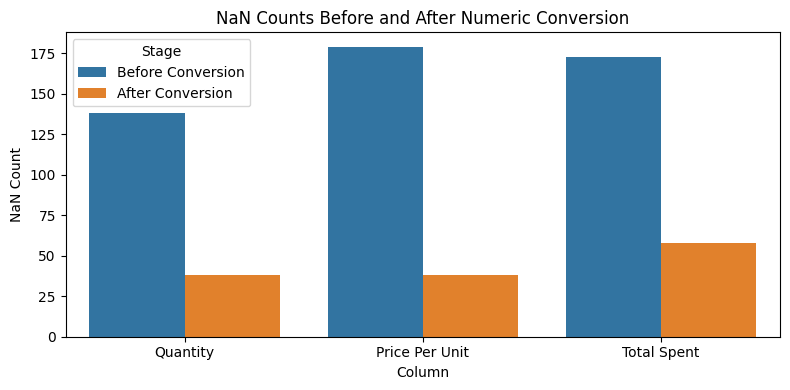

In [176]:
# Comparative bar plot: NaN counts before and after numeric conversion
nan_counts_before = [df['Quantity'].isna().sum(), df['Price Per Unit'].isna().sum(), df['Total Spent'].isna().sum()]
nan_counts_after = [df_clean['Quantity'].isna().sum(), df_clean['Price Per Unit'].isna().sum(), df_clean['Total Spent'].isna().sum()]

nan_compare_df = pd.DataFrame({
    'Column': ['Quantity', 'Price Per Unit', 'Total Spent'],
    'Before Conversion': nan_counts_before,
    'After Conversion': nan_counts_after
})

nan_compare_df_melted = nan_compare_df.melt(id_vars='Column', var_name='Stage', value_name='NaN Count')

plt.figure(figsize=(8,4))
sns.barplot(data=nan_compare_df_melted, x='Column', y='NaN Count', hue='Stage')
plt.title('NaN Counts Before and After Numeric Conversion')
plt.tight_layout()
plt.show()

### Check Invalid Date Entries:
Calculate and display the number of invalid (non-parsable) entries in the 'Transaction Date' column before any date cleaning is applied

In [177]:
# Count invalid date entries before cleaning
invalid_dates_before = pd.to_datetime(df['Transaction Date'], errors='coerce').isna().sum()
print(f"Number of invalid 'Transaction Date' entries before cleaning: {invalid_dates_before}")

Number of invalid 'Transaction Date' entries before cleaning: 460


### Clean and Validate Date Values

Convert the 'Transaction Date' column to datetime, replacing invalid entries with NaT (Not a Time), and filter out or review invalid dates for further cleaning.

In [196]:
# Preview and count invalid 'Transaction Date' entries before conversion

# Find entries that are not null but will become NaT after conversion
invalid_date_mask = pd.to_datetime(df['Transaction Date'], errors='coerce').isna() & df['Transaction Date'].notna()
invalid_dates_before = df.loc[invalid_date_mask, 'Transaction Date']

print(f"Number of invalid 'Transaction Date' entries before cleaning: {invalid_dates_before.shape[0]}")
print("Sample invalid 'Transaction Date' entries before cleaning:")
print(invalid_dates_before.head())

# Convert 'Transaction Date' to datetime, invalid entries become NaT
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')

# Print how many were converted to NaT
converted_to_nat = invalid_dates_before.shape[0]
print(f"Number of entries converted to NaT after conversion: {converted_to_nat}")

Number of invalid 'Transaction Date' entries before cleaning: 301
Sample invalid 'Transaction Date' entries before cleaning:
11       ERROR
29       ERROR
33       ERROR
103      ERROR
115    UNKNOWN
Name: Transaction Date, dtype: object
Number of entries converted to NaT after conversion: 301


### Visualize Invalid 'Transaction Date' Values Before Cleaning

The bar chart below displays the top 10 most frequent invalid date values found in the dataset prior to cleaning.

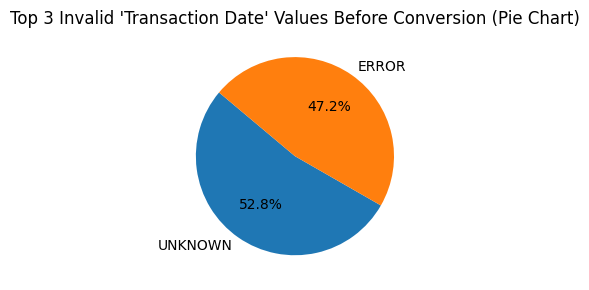

In [222]:
# Count occurrences of each invalid value
invalid_value_counts = invalid_dates_before.value_counts()

# Plot the counts of each invalid value (top 10 for readability) as a pie chart
plt.figure(figsize=(3, 3))
invalid_value_counts.head(3).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Top 3 Invalid 'Transaction Date' Values Before Conversion (Pie Chart)")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Check no Invalid 'Transaction Date' values are left

In [230]:
non_nat = df_clean['Transaction Date'].dropna()
non_datetime = non_nat[~non_nat.apply(lambda x: isinstance(x, pd.Timestamp))]
print("Non-NaT, non-datetime values in df_clean['Transaction Date'] (should be empty):")
print(non_datetime.unique())

Non-NaT, non-datetime values in df_clean['Transaction Date'] (should be empty):
<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


### Check for Duplicate Transaction IDs

Check for duplicate 'Transaction ID' values in both the original and cleaned DataFrames to ensure each transaction is uniquely identified.

In [179]:
#  Check for duplicate Transaction IDs
print("Duplicate Transaction IDs in original df:", df['Transaction ID'].duplicated().sum())
print("Duplicate Transaction IDs in cleaned df_clean:", df_clean['Transaction ID'].duplicated().sum())

Duplicate Transaction IDs in original df: 0
Duplicate Transaction IDs in cleaned df_clean: 0


### Check for Unexpected Payment Method Values
Check for unexpected or inconsistent values in the 'Payment Method' column in both the original and cleaned DataFrames to ensure all payment methods are standardized.

In [180]:
# Check for unexpected Payment Method values
print("Unique Payment Methods in df:", df['Payment Method'].unique())
print("Unique Payment Methods in df_clean:", df_clean['Payment Method'].unique())

Unique Payment Methods in df: ['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]
Unique Payment Methods in df_clean: ['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]


### Standardize Unexpected Payment Method Values

Identify and standardize invalid or inconsistent values in the 'Payment Method' column of the cleaned DataFrame. Values such as 'UNKNOWN', empty strings, and 'ERROR' are replaced with the consistent placeholder 'Unknown' to ensure uniformity in payment

In [181]:
# Define invalid payment method values
invalid_payment_methods = ['UNKNOWN', '', 'ERROR','nan_count_Price_Per_Unit', 'N/A','nan', 'None', 'null', 'NaN', 'NA', 'Unknown' ]

# Count how many will be replaced
num_payment_standardized = df_clean['Payment Method'].isin(invalid_payment_methods).sum() + df_clean['Payment Method'].isna().sum()

# Replace with 'Unknown'
df_clean.loc[df_clean['Payment Method'].isin(invalid_payment_methods), 'Payment Method'] = 'Unknown'
df_clean.loc[df_clean['Payment Method'].isna(), 'Payment Method'] = 'Unknown'

# Print the number of standardized values and unique payment methods
print(f"Standardized {num_payment_standardized} 'Payment Method' values to 'Unknown'.")
print("Unique Payment Methods in df_clean after standardization:", df_clean['Payment Method'].unique())

Standardized 3178 'Payment Method' values to 'Unknown'.
Unique Payment Methods in df_clean after standardization: ['Credit Card' 'Cash' 'Unknown' 'Digital Wallet']


### Visualize Payment Methods before vs after Standarization

The donut chart below displays the distribution of all payment method values found in the raw vs processed dataset after standarization

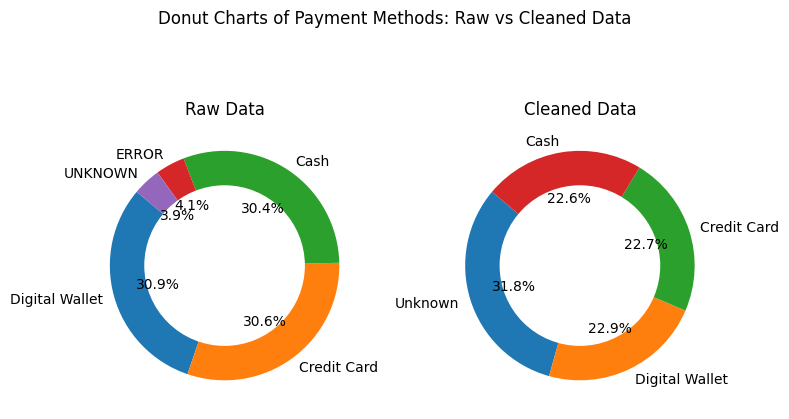

In [234]:
# Show donut charts for payment methods in raw and cleaned data side by side

payment_counts_raw = df['Payment Method'].value_counts()
payment_counts_clean = df_clean['Payment Method'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Raw data donut chart
wedges1, texts1, autotexts1 = axes[0].pie(payment_counts_raw, labels=payment_counts_raw.index, autopct='%1.1f%%', startangle=140)
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
axes[0].add_artist(centre_circle1)
axes[0].set_title("Raw Data")

# Cleaned data donut chart
wedges2, texts2, autotexts2 = axes[1].pie(payment_counts_clean, labels=payment_counts_clean.index, autopct='%1.1f%%', startangle=140)
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
axes[1].add_artist(centre_circle2)
axes[1].set_title("Cleaned Data")

plt.suptitle("Donut Charts of Payment Methods: Raw vs Cleaned Data")
plt.tight_layout()
plt.show()

### Check for Unexpected Location Values

Check for unexpected or inconsistent values in the 'Location' column in both the original and cleaned DataFrames to ensure all locations are standardized.

In [217]:
# Check for unexpected Location values
print("Unique Locations in df:", df['Location'].unique())



Unique Locations in df: ['Takeaway' 'In-store' 'UNKNOWN' nan 'ERROR']


### Standardize Invalid Location Values

Identify and standardize invalid or inconsistent values in the 'Location' column of the cleaned DataFrame. Values such as 'UNKNOWN', empty strings, and 'ERROR' are replaced with the consistent placeholder 'Unknown' to ensure uniformity in location

In [183]:
# Define invalid location values
invalid_location_values = ['UNKNOWN', '', 'ERROR', 'nan_count_Price_Per_Unit', 'N/A', 'nan', 'None', 'null', 'NaN', 'NA', 'Unknown']

# Count how many will be replaced
num_location_standardized = df_clean['Location'].isin(invalid_location_values).sum() + df_clean['Location'].isna().sum()

# Replace with 'Unknown'
df_clean.loc[df_clean['Location'].isin(invalid_location_values), 'Location'] = 'Unknown'
df_clean.loc[df_clean['Location'].isna(), 'Location'] = 'Unknown'


print(f"Standardized {num_location_standardized} 'Location' values to 'Unknown'.")
print("Unique Locations in df_clean after standardization:", df_clean['Location'].unique())

Standardized 3961 'Location' values to 'Unknown'.
Unique Locations in df_clean after standardization: ['Takeaway' 'In-store' 'Unknown']


### Pie Charts Comparing Location Values Before and After Cleaning

The pie charts below compare the distribution of unique `Location` values in the raw dataset (`df`) and the cleaned dataset (`df_clean`). 


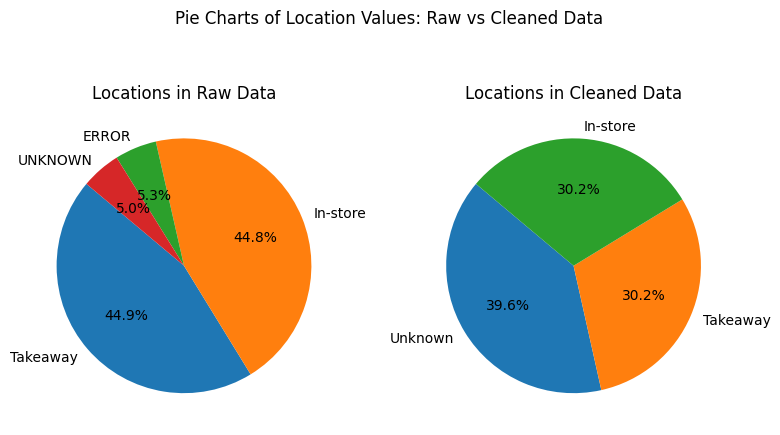

In [235]:

# Pie charts to compare unique Location values in df and df_clean
location_counts_raw = df['Location'].value_counts()
location_counts_clean = df_clean['Location'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Raw data pie chart
axes[0].pie(location_counts_raw, labels=location_counts_raw.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Locations in Raw Data")

# Cleaned data pie chart
axes[1].pie(location_counts_clean, labels=location_counts_clean.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Locations in Cleaned Data")

plt.suptitle("Pie Charts of Location Values: Raw vs Cleaned Data")
plt.tight_layout()

### Check Missing/Invalid 'Item' Values Before Standardization

Count and display the number of missing or invalid values in the 'Item' column

In [184]:
# Check missing or invalid 'Item' values before standardization

invalid_item_values = ['', 'UNKNOWN','Void', 'ERROR']
item_missing_before = df_clean['Item'].isnull() | df_clean['Item'].isin(invalid_item_values)
num_item_before = item_missing_before.sum()
print(f"Missing or invalid 'Item' values before standardization: {num_item_before}")
print("Unique Items in df_clean before standardization:", df_clean['Item'].unique())

Missing or invalid 'Item' values before standardization: 969
Unique Items in df_clean before standardization: ['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'UNKNOWN' 'Sandwich' nan
 'ERROR' 'Juice' 'Tea']


### Standardize Missing or Invalid 'Item' Values

Replace all missing or invalid values in the 'Item' column with the placeholder 'Unknown Item'

In [192]:
# Standardize missing or invalid 'Item' values and print before/after counts

if num_item_before > 0:
    df_clean.loc[item_missing_before, 'Item'] = 'Unknown'

item_missing_after = df_clean['Item'].isnull() | df_clean['Item'].isin(invalid_item_values)

# Standardize missing or invalid 'Item' values
df_clean.loc[item_missing_before, 'Item'] = 'Unknown'

print(f"Standardized {num_item_before} 'Item' values to 'Unknown Item'.")
print("Unique Items in df_clean after standardization:", df_clean['Item'].unique())

Standardized 969 'Item' values to 'Unknown Item'.
Unique Items in df_clean after standardization: ['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'Unknown' 'Sandwich' 'Juice'
 'Tea']


### Check for Future Transaction Dates

Identify and count any 'Transaction Date' values that are set in the future (after today) in both the original and cleaned DataFrames. This helps detect and address potential data entry errors or inconsistencies in

In [186]:
# Check for future Transaction Dates (after today)
now = pd.Timestamp(datetime.now().date())
future_dates_df = (pd.to_datetime(df['Transaction Date'], errors='coerce') > now).sum()
future_dates_clean = (df_clean['Transaction Date'] > now).sum()
print(f"Future Transaction Dates in df: {future_dates_df}")
print(f"Future Transaction Dates in df_clean: {future_dates_clean}")

Future Transaction Dates in df: 0
Future Transaction Dates in df_clean: 0


### Check for Duplicate Rows

Check for duplicate rows (entire row duplicates) in both the original and cleaned DataFrames to identify and address any repeated records in the dataset.

In [187]:
# Check for duplicate rows (entire row duplicates)
dup_rows_df = df.duplicated().sum()
dup_rows_clean = df_clean.duplicated().sum()
print(f"Duplicate rows in df: {dup_rows_df}")
print(f"Duplicate rows in df_clean: {dup_rows_clean}")

Duplicate rows in df: 0
Duplicate rows in df_clean: 0


## Check for Outliers 

Assess the dataset for outliers in Numerical Columns of the dataframe

In [236]:
# Check for outliers (values > 99th percentile) in all numeric columns

numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

for col in numeric_cols:
    q99_orig = pd.to_numeric(df[col], errors='coerce').quantile(0.99)
    q99_clean = df_clean[col].quantile(0.99)
    outliers_orig = (pd.to_numeric(df[col], errors='coerce') > q99_orig).sum()
    outliers_clean = (df_clean[col] > q99_clean).sum()
    print(f"99th percentile of {col} in df: {q99_orig}")
    print(f"99th percentile of {col} in df_clean: {q99_clean}")
    print(f"Number of {col} outliers in df:", outliers_orig)
    print(f"Number of {col} outliers in df_clean:", outliers_clean)


99th percentile of Quantity in df: 5.0
99th percentile of Quantity in df_clean: 5.0
Number of Quantity outliers in df: 0
Number of Quantity outliers in df_clean: 0
99th percentile of Price Per Unit in df: 5.0
99th percentile of Price Per Unit in df_clean: 5.0
Number of Price Per Unit outliers in df: 0
Number of Price Per Unit outliers in df_clean: 0
99th percentile of Total Spent in df: 25.0
99th percentile of Total Spent in df_clean: 25.0
Number of Total Spent outliers in df: 0
Number of Total Spent outliers in df_clean: 0


## Download Cleaned Cafe Sales Data
Click on the link below to downloaded a csv of the cleaned dataframe


In [224]:

# Save cleaned DataFrame to CSV
csv_filename = "cleaned_cafe_sales.csv"
df_clean.to_csv(csv_filename, index=False)

# Display markdown and download link
display(FileLink(csv_filename))

c:\Users\rymot\Desktop\Data Cleaning\notebooks\cleaned_cafe_sales.csv